# Text Analysis of Theft Description

## Introduction

This notebook is the second part to the project; Bicycle Karma: Predicting and tracking bike theft. The first part of the project dealt with understanding all the key features that played a part in a bicycle being stolen. Data was collected from https://bikeindex.org via the provided API, cleaned and run through classification models (decision tree, random forest etc.) as part of the analysis. 

This part deals with analyzing a single text based feature from the dataset; theft description. Bike Index allows for users to type in a description that details on the the theft itself.  As there is a separate field for inputting description of the stolen bike (bicycle), it is appropriate to assume that this field will entail details of the theft alone. Given that description of any theft is bound to vary to the situation itself as well as how it is conveyed by the user, this field provides a great opporunity to explore awhat do users typically share about the bike theft and determine whether there are underlying connections between attributes of the bike itself and the theft descriptions. 

## Clustering

It is important to note that this part of the project does not attempt to predict but tries to group the theft descriptions in to different topics. As there is no preliminary intuition on the different topics within the theft descriptions, we will use text clustering techniques to segregate the theft descriptions in to different topics and interpret the clusters.

The following series of sections will walk you through the process that was followed to explore, analyze and understand the theft description text data.

In [1]:
#Import all libraries used in processing text

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from gensim import corpora, models, similarities
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import nltk
import pprint
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
stopwords=text.ENGLISH_STOP_WORDS
DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='/Users/qubyte/Documents/Harvard-DataScience/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'

## Exploratory Analysis

### Import Data

In [2]:
bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv',encoding='utf-8')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


In [3]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen to non-stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf1 = bike_masterdf[~desc_mask]
desc_mask2 = bike_subdf1.theft_description == ' '
bike_subdf = bike_subdf1[~desc_mask2]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

bike_subdf.to_csv(DATAFILEPATH+'stolen_bikes.csv',encoding='utf-8')
bike_subdf.head(2)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen to non-stolen:  0.56
Number of Stolen bikes with theft description: 28728


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828


### Taking a peek

In the dataframe, the only field of importance for this part of the project is 'theft_description'. The first operation on the data was to filter off the non-stolen bikes as they will not have theft description. This was followed up with cleansing the theft_description field for nulls and invalid entries. It is important to understand how many of the bikes were reported as stolen and how many were weeded out from the cleansing process. As can be noted from above, about 10% of the original data was lost in the cleansing process (33182 to 28728).

The next thing was to understand the data itself prior to any in-depth analysis. Simply looking at data can unravel many intricacies associated with any data set and we did the same with 'theft_description'. We took a look at the first 15 theft descriptions (out of the 28728) and contrary to what can be expected, some of the descriptions are abrupt (e.g. bike rack), some provide the location from where the bike was stolen (e.g.se 19th and se brooklyn) and others talk about a reward.



In [4]:
#Peek at theft description
print (bike_subdf.theft_description[0:15])

3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
14                                         McDonald\\'s
15                                bike rack Reward: 200
16                                bike rack Reward: 200
17                              se 19th and se brooklyn
18    2131 NE 11th Ave Portland, OROut of my garage ...
19                         Outside of 120 NW Trinity Pl
Name: theft_description, dtype: object


### Basic metrics about theft description text

It is important to know whether all the descriptions are short/long in nature. This aids in doing in-depth analysis when parameters tied to 'number of words' in each document can be aptly tuned. It also helps develop an intuition for the dataset in general.

Theft description with maximum word count: 558
Theft description with minimum word cunt:  1
Average word count of description: 10.61


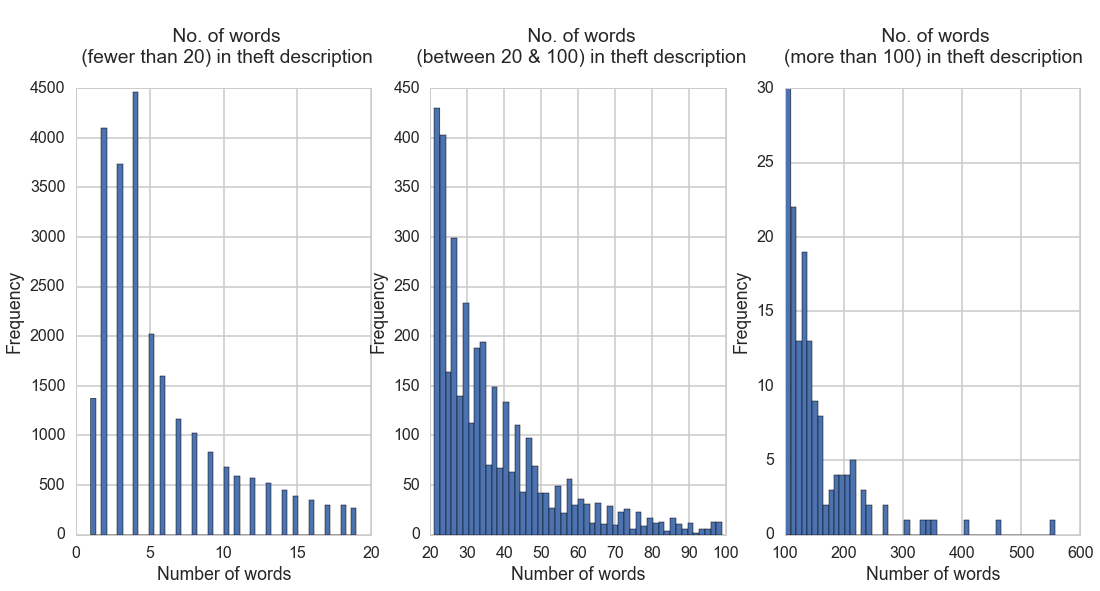

In [5]:
#Peek at the description data - Basic exploratory analysis

# Split each theft description to number of words to get an idea of how long the descriptions are
# exploratory
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))


print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 20]
theft_desc_word_count_mid = theft_desc_word_count[(theft_desc_word_count > 20) & (theft_desc_word_count < 100)]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
#theft_desc_word_count_small.tolist

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), tight_layout=False)
#fig.suptitle('Histogram of words\n\n\n', fontsize=25)
ax1.hist(theft_desc_word_count_small.tolist(), bins=50,histtype='bar' )
ax1.set_title('\n No. of words \n (fewer than 20) in theft description\n')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')
ax2.hist(theft_desc_word_count_mid.tolist(), bins=50,histtype='bar' )
ax2.set_title('\n No. of words \n (between 20 & 100) in theft description\n')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Frequency')
ax3.hist(theft_desc_word_count_large.tolist(), bins=50,histtype='bar' )
ax3.set_title('\n No. of words \n(more than 100) in theft description\n')
ax3.set_xlabel('Number of words')
ax3.set_ylabel('Frequency')

### Theft description as a bunch of words

The above histogram paint an interesting picture about the user's effort when descirbing bike theft. The average number of words per description is about 10-11 with some descriptions as long as 558 words and some as short as 1 word. A large number of theft descriptions are fewer than 5 words, with 2 and 4 words per description being the most common. There appears to be 3 segments of users:

- A large majority who write very very short descriptions about bike theft
- A few who write anywhere between 50-80 words
- very very few that write a lot 

It goes to show that bike owners typically take less interest (very few words) in detailing the theft or perhaps are to the point (e.g reward: $150). It can also be assumed that those who chose to write few words had less expensive bikes and those who chose to write more than 100 words. probably had expensive bikes (wanted to give as much information as possible) or are really thorough. 

### Text Parsing

Having taken a peek at the data, it is now time to dive deep. We start off with defining what exactly are we looking for in the theft description. 

#### Parse Nouns
As we have seen earlier, each owner posting theft description has their own style, can decide to be very specific or elaborate about the theft, could decide to focus on location of theft and describing the bike itself or could describe the circumstances yielding to the bike theft. We start with gathering only the nouns from the description as nouns would give an idea of the 'what'and 'where'.  (We are omitting to interpret the 'when' in this case)

Note that the 'where' is already available in terms if 'location/city/coordinates' in the data. However, in this analysis, we will be focussing on the attributes associated with the location from where the bike was stolen. The noun would also allow us to explore other aspects of the bicycle theft.


Note: As part of the stop words used for parsing the text, the words 'bike' and 'bicycle' were added to the stop words to avoid cluttering the parsed words with redundant information. The following cells detail on how theft description was parsed.

In [30]:
#Setup for text parsing
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS

#Since we are looking for only nouns, we want to avoid parsing for most popular words such as 'bike' and 'bicycle'
CUSTOM_STOPWORDS_NOUN=['bike', 'bicycle']
CUSTOM_STOPWORDS=['bike', 'bicycle']



In [7]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns

def gather_nouns(thetext, cust_words_list=[]):
    NEW_CUST_STOPWORDS_NOUN = CUSTOM_STOPWORDS_NOUN
    if (len (cust_words_list) > 0):
        
        for x in range(len(cust_words_list)):
            tempvar1 = cust_words_list
            NEW_CUST_STOPWORDS_NOUN.extend(tempvar1)
            
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in NEW_CUST_STOPWORDS_NOUN or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)




In [8]:
# Test parsing functions to understand if parsing will be fine
# Following sentence was constructed on the fly and does not belong to the BikeIndex data

atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano \
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was \
stolen from their home's open garage overnight reward"

print gather_nouns(atext)
print "\n"






sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage reward




In [9]:
# Parse Theft description for Nouns 
# Clean resulting data frame to remove null entries where no nouns were parsed from theft description
# Apply gather_nouns function, convert to dataframe and attach to original data frame for storing to file

noun_parsed = bike_subdf.theft_description.apply(gather_nouns)

noun_parsed = noun_parsed.to_frame()

noun_parsed.columns = ['theft_desc_nouns']

print "shape of data frame before appending parsed nouns: ", bike_subdf.shape
#Merge new dataframe with original
newdf = pd.concat([bike_subdf, noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_a = newdf.theft_desc_nouns == ''
bike_dfA = newdf[~null_mask_a].copy()

nullmask_a1 = bike_dfA.theft_desc_nouns.isnull()
bike_df_Nouns = bike_dfA[~nullmask_a1].copy()

print "shape of data frame after appending parsed nouns: ", bike_df_Nouns.shape
bike_df_Nouns['theft_desc_nouns'].head(10)

shape of data frame before appending parsed nouns:  (28728, 57)
shape of data frame after appending parsed nouns:  (28402, 58)


3                          rack
4               car rack reward
5         backyard reward money
6                 garage reward
7     steel hand railing u-lock
8            powell park reward
9               campus division
10                       reward
11        rack reward hug money
14                     mcdonald
Name: theft_desc_nouns, dtype: object

#### Taking a peek at the gathered nouns

From the above results, it is evident that a lot of samples were tossed away as they did not contain nouns or contained words that were rejected by the stopwords. We lost another 10% of data and once could argue that we are gathering nouns at the cost of losing data. However, the key thing to note is that we are only interested in the nouns. Secondly, as there was an abundance of 1 word description and 2 word descriptions, it is likely that they were not nouns and were part of the english 'stopwords'.

### Term-Frequency matrix

The next step is to convert the collection of text in to a matrix of token counts. In this study, we are interested in the frequency of a word/group of words appearing in theft descriptions. The more frequent a word/group of words appear(s), the more weight it should be given. Hence we will use the Term-Frequency (TF) approach and not the Term Frequency-Inverse Document Frequency as it would give less weight to words that are more frequent within and across the documents.

In [10]:
#Tokenize each theft description to return a list of nouns (ONLY)
# We will remove words whose word count is less than 2

vectorizer_nouns = CountVectorizer(min_df=2, stop_words='english')
nouns_sparse_matrix = vectorizer_nouns.fit_transform(bike_df_Nouns.theft_desc_nouns)

In [11]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit

Nouns = vectorizer_nouns.get_feature_names()
Noun_Counts = np.asarray(nouns_sparse_matrix.sum(axis=0)).ravel()
Nouns_Freq = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
Sorted_Nouns_Freq = Nouns_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Freq.to_csv(DATAFILEPATH+'Nouns_frequency.csv',encoding='utf-8')

### Nouns

It is important to understand the frequency of the nouns in the descriptions as they describe the 'what' and 'where' of the theft. Some nouns will be used more frequently than others and other nouns could not be relevant (skew the data) to our study. In the following charts, we can preset top 90 most frquenct nouns in the parsed bag of words. 

In [15]:
# Plot bar graph of Frequency of top  words that were vectorized 
#
def plot_freq_chart(nrows, ncols, df_in, title_in, figw=16, figh=16) :
    x_label = df_in.columns[1]
    y_label = df_in.columns[0]
    plt_rows = np.arange(nrows)
    plt_cols = np.arange(ncols)
    f1, ax1 = plt.subplots(figsize=(figw,figh), nrows=nrows, ncols=ncols)
    #f1.suptitle("Top Nouns - unigram", fontsize=25)
    f1.set_tight_layout(True)
    x = 0
    #sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[0:10])
    for row in plt_rows:
        for col in plt_cols:
            a = sns.barplot(x=x_label,y=y_label,data=df_in[x:x+10], ax=ax1[row][col])
            #print row,col
            a.set_xticklabels(df_in[x_label][x:x+10].tolist(), rotation='vertical')
            a.set_ylabel('Word Frequency')
            a.set_title(title_in)
            x+=10
        x+=10

nrows=3
ncols=3



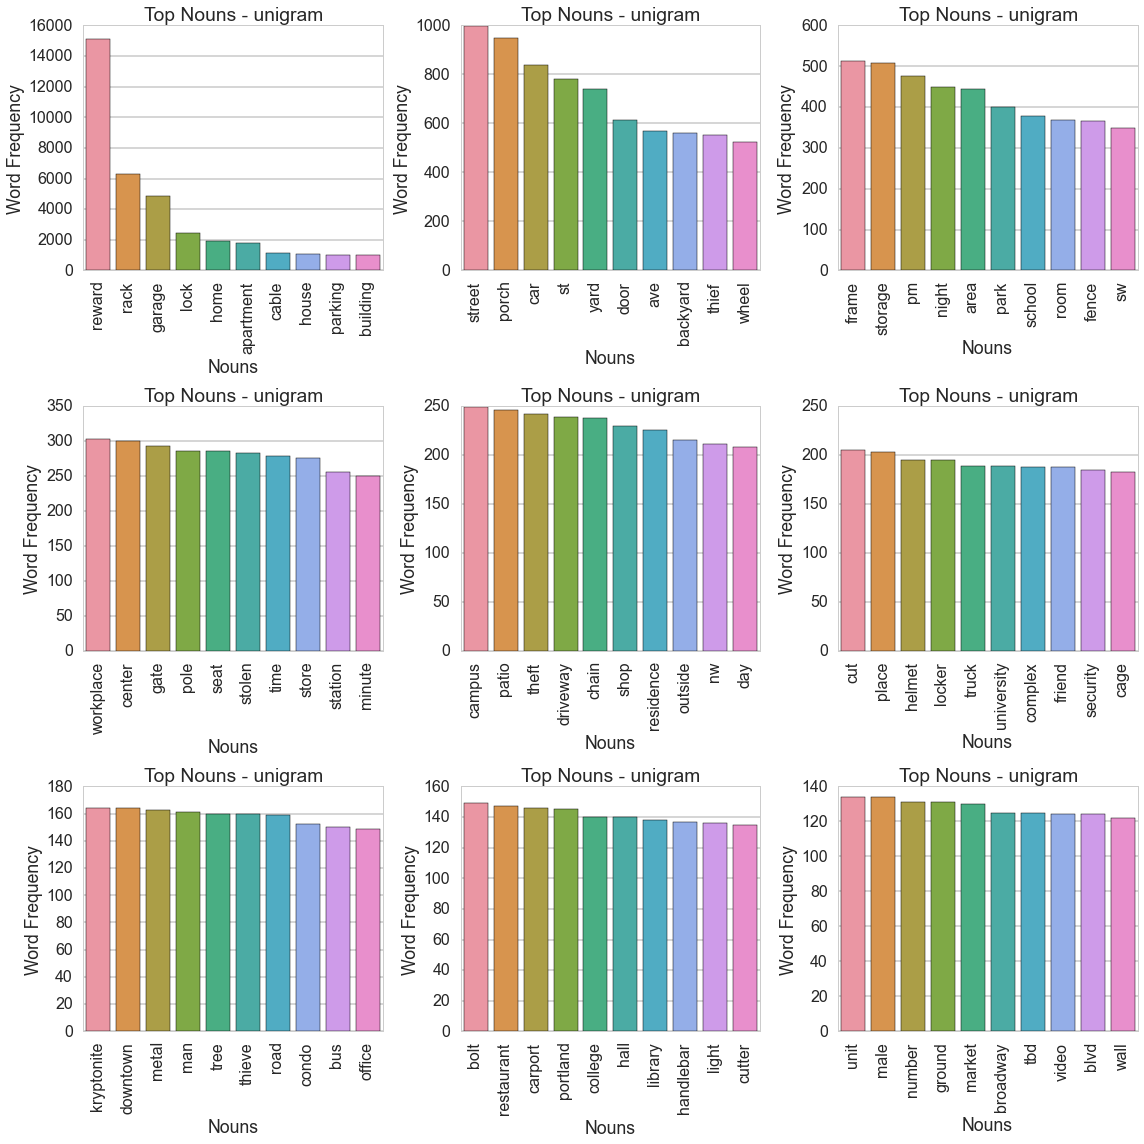

In [16]:
plot_freq_chart(3,3,Sorted_Nouns_Freq, "Top Nouns - unigram")

### Analysis of Nouns Word count

It is very surprising to note that the word 'reward' is the most frequently used word in the descriptions. Shows that a lot of bike owners are willing to give a reward if a bike was found. However, given the high frequency of the word ('reward') and the fact that we are looking for term frequency within each document (theft description), it is important to remove the word, reward, from the descriptions to allow for other words to surface. 

Looking at the other words in list, there is a lot of information available on exactly where the bike was stolen from. The above chart indicates that we may be missing part story if only focussing on the nouns. Here are few examples to illustrate the point:

a) word: rack
The word rack alone is unable to convey much information as the bicycle could have been on a rack in the garage, on the street, in a building etc.  

b) word: condo
Simply parsing the nouns for unigram definitely yields in disecting words such as condo apartment, resulting in two separate words; condo and apartment.

c) word: friend
The word friend by itself does not provide any information about the 'where' or 'what' that we are interested in. 

d) word: pole
The word pole is mostly associated with another noun and we lose the context of the description by looking for unigrams alone

The above exploration of the nouns word count indicates that looking at unigrams alone may/may not be helpful in identifying the 'what' that we are interested in.  To help us understand the descriptions better, we will proceed with parsing for bi-grams along with 'adjectives' in order to provide more meaning to words such as 'bolt', 'chain', 'room', 'fence' etc.


In [17]:
print gather_nouns(atext, ['reward'])
print "\n"

sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage




In [18]:
#Recalculate dataframe and nouns vector after excluding above identified stop words: 'reward'

new_noun_parsed = bike_subdf.theft_description.apply(gather_nouns,cust_words_list=['reward'])

new_noun_parsed = new_noun_parsed.to_frame()

new_noun_parsed.columns = ['theft_desc_nouns']

print "shape of data frame before appending parsed nouns: ", bike_subdf.shape
#Merge new dataframe with original
newdf_B = pd.concat([bike_subdf, new_noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_b = newdf_B.theft_desc_nouns == ''
bike_dfB = newdf_B[~null_mask_b].copy()

nullmask_b1 = bike_dfB.theft_desc_nouns.isnull()
bike_df_Nouns_final = bike_dfB[~nullmask_b1].copy()


vectorizer_nouns_final = CountVectorizer(min_df=2, stop_words='english')
nouns_sparse_matrix_final = vectorizer_nouns_final.fit_transform(bike_df_Nouns_final.theft_desc_nouns)



shape of data frame before appending parsed nouns:  (28728, 57)


In [19]:
bike_df_Nouns_final.to_csv(DATAFILEPATH+'bikes_trim_nouns.csv',encoding='utf-8' )

In [21]:
#Vectorize and gather word count upon removing 'reward'
rrr_Nouns = vectorizer_nouns_final.get_feature_names()
rrr_Noun_Counts = np.asarray(nouns_sparse_matrix_final.sum(axis=0)).ravel()

rrr_Nouns_Freq = pd.DataFrame({'Nouns': rrr_Nouns, 'Count':rrr_Noun_Counts})
rrr_Sorted_Nouns_Freq = rrr_Nouns_Freq.sort(columns='Count', ascending=False)
rrr_Sorted_Nouns_Freq.to_csv(DATAFILEPATH+'Nouns_trimmed_frequency.csv',encoding='utf-8')

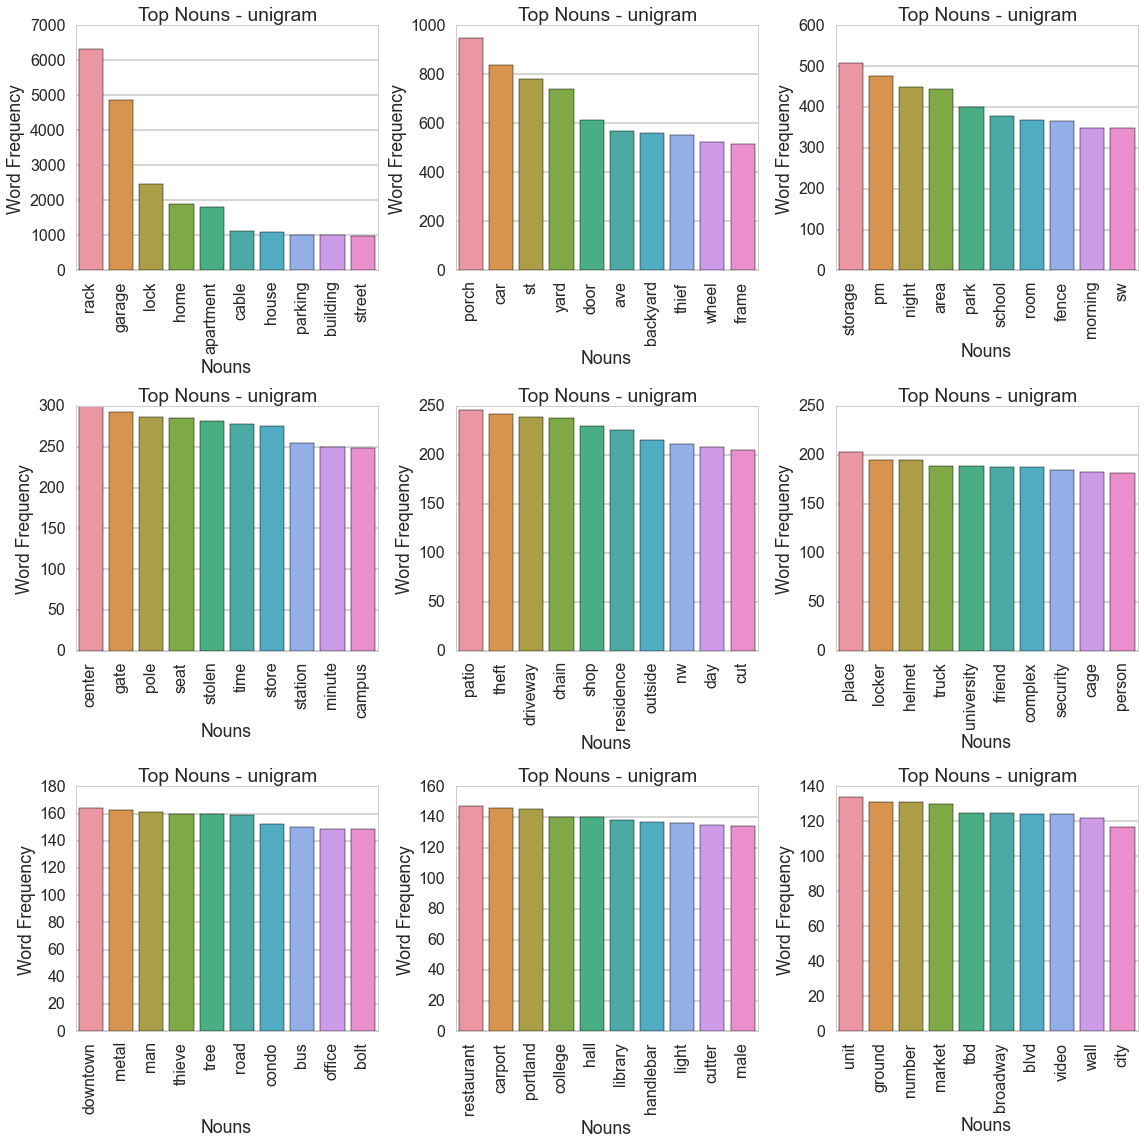

In [22]:
#Plot chart of word counts 
plot_freq_chart(3,3,rrr_Sorted_Nouns_Freq, "Top Nouns - unigram")

### Adjectives

While nouns can help clearly identify the location, the nature of the theft and other details about the theft, without the adjectives, we are likely to be missing out on information. e.g if a theft description was: 'bike stolen from inside garage'. Our unigram noun parser will identify 'stolen' and 'garage'. We lose details on whether it was a theft involving a break in/lock compromise or whether it was from an open garage. Hence to ensure that we don't miss out on any benefits that arise from including the adjectives, the following parses looks for both nouns and adjectives.


In [31]:
def gather_nouns_and_adj(thetext, cust_words_list=[]):
    NEW_CUST_STOPWORDS = CUSTOM_STOPWORDS
    if (len (cust_words_list) > 0):

        for x in range(len(cust_words_list)):
            tempvar2 = cust_words_list
            NEW_CUST_STOPWORDS.extend(tempvar2)

        
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','NNP','JJ','JJR','JJS' ]:
                    if token[4] in NEW_CUST_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [32]:
print gather_nouns_and_adj(atext)
print "\n"

sign pole apartment corner superstore lock combination lock helmet good security block apartment make gt shimano gear custom seat apartment security office chance counsin home open garage overnight reward




In [33]:
##############################################################################################
#Approaching parsing for adjective and noun 

#Based on decision with nouns, we will remove 'reward' from 1+ n grams
noun_adj_parsed = bike_subdf.theft_description.apply(gather_nouns_and_adj,cust_words_list=['reward'] )
noun_adj_parsed = noun_adj_parsed.to_frame()
noun_adj_parsed.columns = ['theft_desc_nouns_adj']

#Merge new dataframe with original
bike_df_temp = bike_subdf.copy()
print "bike data frame shape before appending bigrams: ", bike_df_temp.shape

newdf1 = pd.concat([bike_df_temp, noun_adj_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_b = newdf1.theft_desc_nouns_adj == ''
bike_df_B = newdf1[~null_mask_b]

nullmask_b1 = bike_df_B.theft_desc_nouns_adj.isnull()
bike_df_Nouns_Adj = bike_df_B[~nullmask_b1]

print "bike data frame shape after appending bigrams: ", bike_df_Nouns_Adj.shape
bike_df_Nouns_Adj.head(2)



bike data frame shape before appending bigrams:  (28728, 57)
bike data frame shape after appending bigrams:  (26092, 58)


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch,theft_desc_nouns_adj
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369,rack
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828,car rack


In [34]:
bike_df_Nouns_Adj.to_csv(DATAFILEPATH+'bikes_trim_nouns_adj.csv',encoding='utf-8' )



A preliminary peek in to the dataframe created from parsing for adjectives and nouns already seems fruitful in floating more detail. e.g. 'open garage' which we did not see earlier when parsing for nouns only. 

### Bigram analysis

Upon identifying both nouns and adjectives, we can create a bag words based on adjectives and nouns as unigrams. However, adjectives alone will irrelevant without nouns. Hence we will work with bigrams where we increase the chances of an adjective and a noun being picked together.  Note that we are not treating for 'either' order of words as this is only an exploratory step e.g 'bike stolen from car rack' and 'Bike was attached to rack beside car' would both yeild 'car rack' and 'rack car' as one of the bigrams. In this case, the context is entirely different for both the sentences and hence it is acceptable to have them as seperate bigrams but there could be other cases where this could behave otherwise.

In [35]:
#Vectorizer for bigrams on both Nouns and Adjectives
vectorizer_nouns_adj = CountVectorizer(min_df=2, ngram_range=(2,2), stop_words='english')
nouns_adj_sparse_matrix = vectorizer_nouns_adj.fit_transform(bike_df_Nouns_Adj.theft_desc_nouns_adj) 

Nouns_Adj = vectorizer_nouns_adj.get_feature_names()
Nouns_Adj_Counts = np.asarray(nouns_adj_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_Freq = pd.DataFrame({'Nouns_Adjectives': Nouns_Adj, 'Count':Nouns_Adj_Counts})
Sorted_Nouns_Adj_Freq = Nouns_Adj_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_frequency.csv',encoding='utf-8')

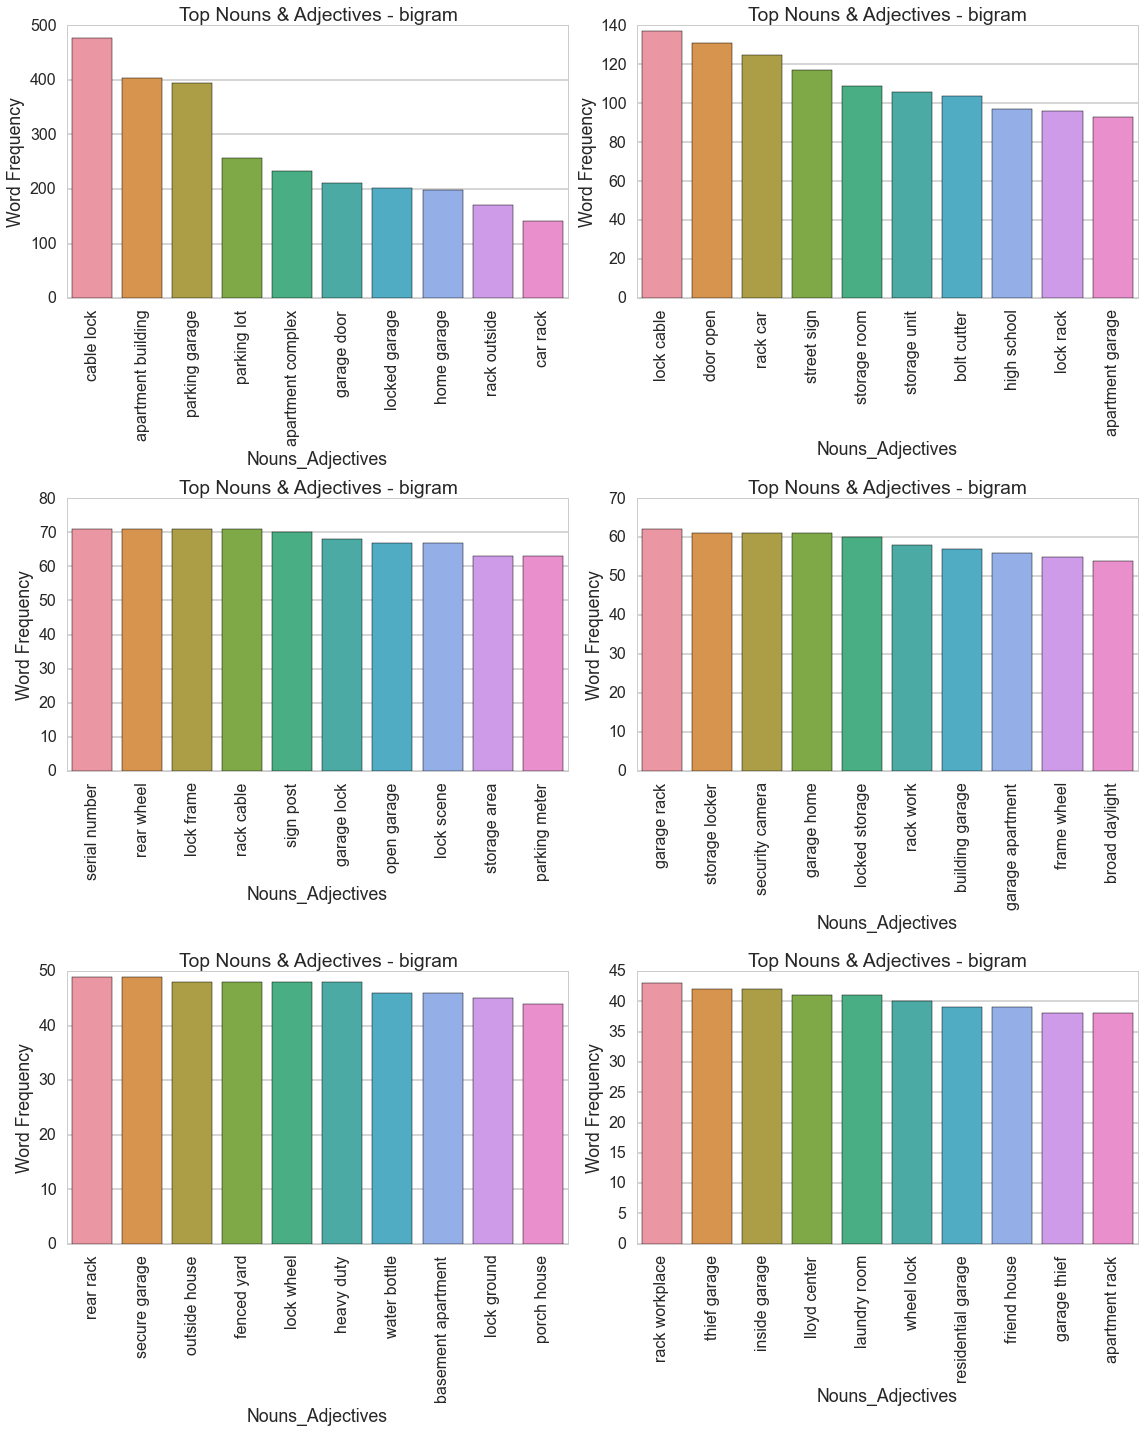

In [36]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_Freq, "Top Nouns & Adjectives - bigram", figw=16, figh=20)



The above bigram charts are far more descriptive in aptly identifying some of the key elements of each of the descriptions. It is definitely likely that a single description of theft had more than 1 combination of the bigrams identified above. e.g. a theft description could have had both these bigrams ['door open' & 'parking garage'] or ['bike stolen' & 'outside apartment']. 

This yeilds to an interesting question. So how many n-grams would be perfect? This all depends on what exactly are we looking at. The main focus of the theft description analysis is to identify specifics tied to the location from where a bike was stolen. We shall further our exploration with a tri-gram and attempt to create similar charts as earlier to better equip us for clustering.

In [37]:
#Vectorizer for trigrams on Nouns and Adjectives
vectorizer_nouns_adj_trigram = CountVectorizer(min_df=2, ngram_range=(3,3), stop_words='english')
nouns_adj_trigram_sparse_matrix = vectorizer_nouns_adj_trigram.fit_transform(bike_df_Nouns_Adj.theft_desc_nouns_adj) 

Nouns_Adj_trigram = vectorizer_nouns_adj_trigram.get_feature_names()
Nouns_Adj_trigram_Counts = np.asarray(nouns_adj_trigram_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_trigram_Freq = pd.DataFrame({'Nouns_Adjectives_TRIGRAM': Nouns_Adj_trigram, 'Count':Nouns_Adj_trigram_Counts})
Sorted_Nouns_Adj_trigram_Freq = Nouns_Adj_trigram_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_trigram_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_Trigram_frequency.csv',encoding='utf-8')

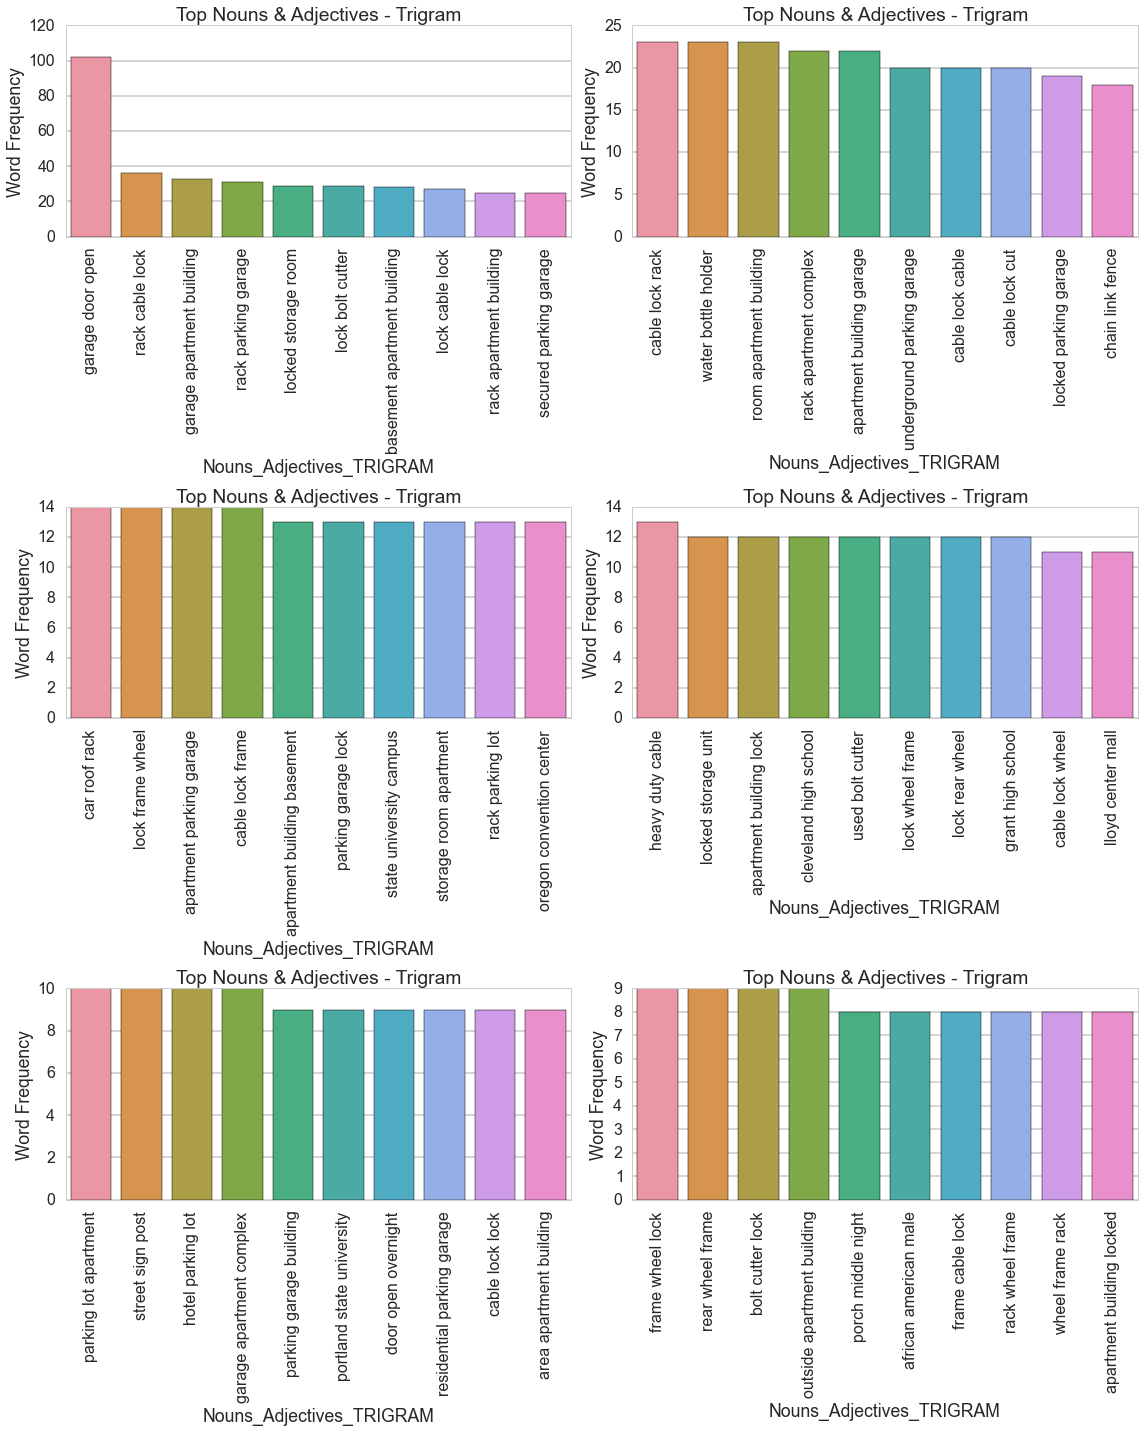

In [38]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_trigram_Freq, "Top Nouns & Adjectives - Trigram",figw=16, figh=20)

### Trigram Analysis

It appears that trigram are conveying lots more information about the 'where' that we are interested in. At this point, we should keep in mind that the vast majority of the descriptions had fewer than 5 words. It is very subjective as to whether the trigrams are better than the bigrams. One interesting aspect of trigrams is that we eliminate the issue of order as in most of the cases the context of the description will be aptly captured by the trigram.



### Digging Deeper

At this point, we need to understand the multidimensional space of the unigram corpus and trigram sparse matrices . A 2D representation will assist in better understanding any clusters that are present in the multi-dimensional space. MDS  (Multi Dimensional Scaling) can be used to obtain a 2D representation of both our unigram and trigram corpus. 


The following section details on how MDS  was applied to a 20% random sample for both the unigrams (Nouns only) and trigrams (Nouns&Adjectives).


#### Cosine similarity

The cosine measure similarity is another similarity metric that depends on envisioning user descriptions as points in space. Each theft description from the users can be envisioned as a point in n-dimensional space. The cosine similarity calculates the angle between any of the two vectors in the n-dimensional space. Hence, for vectors that are close to each other/along the same direction ((similar theft descriptions), the difference in angle between them will be very small and vice versa.  


In [39]:
#Define function to obtain MDS coordinates of text data
#Credit https://de.dariah.eu/tatom/working_with_text.html

def get_mds(df_in, sample_size, nouns_only=True, ngram=1,num_jobs=1):
    dftouse = df_in.copy()
    itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=sample_size)
    #print len(itrain)
    mask=np.ones(dftouse.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    #print mask.shape, mask.sum()
    if (nouns_only):
        print "MDS on Nouns only"
        rand_sample_text = dftouse['theft_desc_nouns'][mask]

    else:
        print "MDS on Nouns & Adjectives only"
        rand_sample_text = dftouse['theft_desc_nouns_adj'][mask]
        
    print rand_sample_text.shape
    #Remove null entries from parsed text
    nullmask_A = rand_sample_text.isnull()
    rand_sample_text = rand_sample_text[~nullmask_A].copy()

    #print len(rand_sample_text)
    vectorizer_rand_sample = CountVectorizer(min_df=2,ngram_range=(ngram,ngram),stop_words='english') #  
    rand_sample_sparse_matrix = vectorizer_rand_sample.fit_transform(rand_sample_text) 
    #rand_sample_feature_names = vectorizer_rand_sample.get_feature_names()
    #rand_sample_theft_desc = dftouse['theft_description'][mask].tolist()
    #rand_sample_nouns_adj = dftouse['theft_desc_nouns_adj'][mask].tolist()
    
    #rand_sample_full_matrix = rand_sample_sparse_matrix.toarray()
    distance_euc = euclidean_distances(rand_sample_sparse_matrix)
    
    distance_cos = cosine_similarity(rand_sample_sparse_matrix)
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, n_jobs=num_jobs)
    pos_euc = mds.fit_transform(distance_euc)
    pos_cos = mds.fit_transform(distance_cos)
    
    return pos_euc, pos_cos




In [40]:

def mds_scatterplot(pos_euc, pos_cos, sample_size, fig_text):
    xs_euc, ys_euc = pos_euc[:, 0], pos_euc[:, 1]
    xs_cos, ys_cos = pos_cos[:, 0], pos_cos[:, 1]

    fig6, (ax6,ax7) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), tight_layout=True)
    s_size = float(sample_size)*100
    fig_title = 'MDS scatter plots - Representing,', s_size, '% random sample of dataset'+fig_text
    fig6.suptitle(fig_title, fontsize=20)
    ax6.set_title('\n\nEuclidean distance')
    for x, y in zip(xs_euc, ys_euc):
        ax6.scatter(x, y, marker='o',alpha=0.5)

    ax7.set_title('\n\nCosine distance')
    for x, y in zip(xs_cos, ys_cos):
        ax7.scatter(x, y, marker='o',alpha=0.5)

In [41]:
#Define sample size to be used for MDS plot
sample_size_for_mds = 0.2

In [ ]:
# Get MDS for Unigrams on xx% subset of data (random sampling)
Nouns_sample_size=sample_size_for_mds
euc_1gram, cos_1gram = get_mds(bike_df_Nouns_final,sample_size=Nouns_sample_size, nouns_only=True, ngram=1)

In [ ]:
#MDS scatter plot for unigrams (nouns only)
mds_scatterplot(euc_1gram, cos_1gram, 0.1, ' for Unigram')

In [ ]:
# Get MDS for trigrams on xx% subset of data (random sampling)
Nouns_Adj_sample_size=sample_size_for_mds
euc_3gram, cos_3gram = get_mds(bike_df_Nouns_Adj,sample_size=Nouns_Adj_sample_size, nouns_only=False, ngram=3)

In [ ]:
#MDS Scatter plot for trigrams (nouns and adjectives)
mds_scatterplot(euc_3gram, cos_3gram, 0.1, ' for Trigrams')

#### Note: Given that this is unsupervised learning, the entire dataframe will be used in the analysis instead of splitting in to training and testing sets.

In [ ]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_sig_words(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing top ", num_sig, " significant words for each topic:"
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", key

        pp.pprint (lda_model_in[key])



In [ ]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_Umass_topics_coh(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing Umass topic coherence for each topic."
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", key

        pp.pprint (lda_model_in[key])



In [ ]:
#Finalize variables for Trigrams

sparse_matrix_trigram = nouns_adj_trigram_sparse_matrix
vectorizer_trigram = vectorizer_nouns_adj_trigram

In [ ]:
#Obtain vocabulary index for trigrams
#Convert trigram sparse matrix to corpus

id2words_trigram= dict((v, k) for k, v in vectorizer_trigram.vocabulary_.iteritems())

corpus_gensim_trigram = gensim.matutils.Sparse2Corpus(sparse_matrix_trigram, documents_columns=False)

print "Corpus shape of trigram: ", corpus_gensim_trigram.sparse.get_shape()
print "Number of words in trigram vocabulary: ", len(vectorizer_trigram.vocabulary_)

In [ ]:
#Perform LDA for different topic size on the trigram
print "Corpus shape for trigram:", corpus_gensim_trigram.sparse.shape
num_sig_words=10
num_topics_corpus=range(2,4)
lda_models_Umass_topic_coh={}
lda_models_sig_words={}
for eachtopic in num_topics_corpus:
    lda_text = gensim.models.ldamodel.LdaModel(corpus_gensim_trigram,alpha='auto', id2word=id2words_trigram, num_topics=eachtopic, update_every=1, chunksize=1000, passes=5)
    lda_models_Umass_topic_coh[eachtopic]=lda_text.top_topics(corpus_gensim_trigram,num_words=num_sig_words)
    lda_models_sig_words[eachtopic]=lda_text.show_topics(num_topics=eachtopic, num_words=num_sig_words, log=False, formatted=True)

In [ ]:
print "For Trigrams:"
print_sig_words(lda_models_sig_words, num_sig_words)


### UMass Topic Coherence
UMass measure is computing p(rare word | common word), how much a common word triggers a rarer word. However, in human word association, high frequency words are more likely to be used as response words than low frequency words ( Quentin Pleplé , Topic Coherence To Evaluate Topic Models)

In [ ]:
print "For Trigrams:"
print_Umass_topics_coh(lda_models_Umass_topic_coh,num_sig_words)

In [ ]:
#Finalize variables for easier naming convention
#Select which model to use and assign it to final variable

vectorizer_final = vectorizer_nouns_final
sparse_matrix_final = nouns_sparse_matrix_final

id2words_final= dict((v, k) for k, v in vectorizer_final.vocabulary_.iteritems())
corpus_gensim_final = gensim.matutils.Sparse2Corpus(sparse_matrix_final, documents_columns=False)

In [ ]:
#Confirm that the word 'reward' is not the vectorizer vocabulary

'reward' in vectorizer_final.vocabulary_

In [ ]:
#Perform LDA on final corpus - Unigram

#Perform LDA for different topic sizes
print "Corpus shape for unigram (nouns only):", corpus_gensim_final.sparse.shape
num_sig_words_final=10
num_topics_final=range(3,6)
lda_final_Umass_topic_coh={}
lda_final_sig_words={}
lda_model_nouns_dict={}
for eachtopic in num_topics_final:
    lda_model_nouns_dict[eachtopic] = gensim.models.ldamodel.LdaModel(corpus_gensim_final,
                                                     alpha='auto', 
                                                     id2word=id2words_final, 
                                                     num_topics=eachtopic, 
                                                     update_every=1, 
                                                     chunksize=1000,
                                                     passes=5)
    lda_final_Umass_topic_coh[eachtopic]=lda_model_nouns_dict[eachtopic].top_topics(corpus_gensim_final,
                                                                    num_words=num_sig_words_final)
    lda_final_sig_words[eachtopic]=lda_model_nouns_dict[eachtopic].show_topics(num_topics=eachtopic, 
                                                               num_words=num_sig_words_final, 
                                                               log=False, 
                                                               formatted=True)

In [ ]:
print "For Unigrams:"
print_sig_words(lda_final_sig_words, num_sig_words_final)

In [ ]:
print "For Unigrams:"
print_Umass_topics_coh(lda_final_Umass_topic_coh,num_sig_words_final)

In [ ]:
#Build Dictionary of all Nouns
dictionary =  corpora.dictionary.Dictionary.from_corpus(corpus_gensim_final, id2words_final)
print dictionary

In [ ]:
def get_doc_topic(noun_in, lda_model_in, num_clust=3):
    #print type(noun_in)
    kk = noun_in.split()
    bagofwords = dictionary.doc2bow(kk)
    #print bagofwords
    topic_prob = lda_model_in[num_clust].get_document_topics(bagofwords)
    imp_prob_val = 0
    imp_topic = 0
    for i in range(num_clust):
        a,b = topic_prob[i]
        if b> imp_prob_val:
            imp_prob_val = b
            imp_topic = a
    imp_prob_val_r = float("{0:.2f}".format(imp_prob_val))
    return imp_prob_val_r, imp_topic        #, topic_prob          #****** Add if necessary for output 


In [ ]:
#Temp to del
#get_doc_topic(bike_df_Nouns_final['theft_desc_nouns'].loc[100], lda_model_nouns_dict, num_clust=3)

In [ ]:
#Copy Nouns DataFrame
df_N_topic_analysis = bike_df_Nouns_final.copy()

#Call get_doc_topic function on each nouns to understand topic probability definition found by LDA
#Define number of clusters
n_clust = 3
x = df_N_topic_analysis.theft_desc_nouns.apply(get_doc_topic, lda_model_in =lda_model_nouns_dict, num_clust=3)
#print len(x)

In [ ]:
#Prepare new dataframe to append to original with probability and topic details
list_prob=[]
list_topic=[]
for a,b in x:
    list_prob.append(a)
    list_topic.append(b)
Topic_Prob = {'Topic_Prob': list_prob}
Topic_Type = {'Topic': list_topic}

topicdf = pd.DataFrame({'Topic_Prob': list_prob, 'Topic': list_topic})

    

In [ ]:
df_N_topic_analysis = df_N_topic_analysis.reset_index(drop=True)
#Merge new dataframe with original
df_LDA_ANALYZED= pd.concat([df_N_topic_analysis, topicdf], axis=1)


#Verify shape of DF is the same as before analysis
#print df_LDA_ANALYZED.shape

print "Shape of Dataframe before appending Topic details:" , df_N_topic_analysis.shape
print "Shape of topic DataFrame:", topicdf.shape
print "Shape of combined DataFrame: ", df_LDA_ANALYZED.shape

In [ ]:
df_LDA_ANALYZED.to_csv(DATAFILEPATH+'df_LDA_ANALYZED.csv',encoding='utf-8')
df_LDA_ANALYZED.head(4)


In [ ]:

#For a 3 topic based analysis

print "Analyzing corpus assuming all theft descriptions can be classified in to 3 topics"

for i in range(3):
    
    x = len(df_LDA_ANALYZED.Topic[df_LDA_ANALYZED.Topic == i])
    print "Number of documents with highest probability in Topic ",i ," :", x
    
    

### Supplementary

We did pursue spectral clustering as well but our cluster definitions were not as good as the ones that we interpreted from LDA. 

The following has been provided to allow for future expansion of this project (our own interest) and find ways to tune the corpus as well as the spectral clustering model.

### # In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plan.

When calling fit, an affinity matrix is constructed using either kernel function such the Gaussian (aka RBF) kernel of the euclidean distanced d(X, X):

From: http://scikit-learn.org/stable/modules/clustering.html
Note that if the values of your similarity matrix are not well distributed, e.g. with negative values or with a distance matrix rather than a similarity, the spectral problem will be singular and the problem not solvable. In which case it is advised to apply a transformation to the entries of the matrix. 

Hence we will be using cosine similarity

In [ ]:
# Function to write clusters dervied from spectral clustering to file
def clusters_to_file(dfin, model_labels, min_clust, max_clust, file_name):
    num_clust_n = np.arange(min_clust,max_clust+1)
    dftemp = dfin.copy()
    for i in num_clust_n:
        clust = pd.Series(model_labels[i].labels_)
        clust_name='Noun_Clusters_'+str(i)
        dftemp[clust_name]=clust.values
    dftemp.to_csv(DATAFILEPATH+file_name, encoding='utf-8')
    return dftemp





#### Spectral Clustering on nouns

In [ ]:
#Run spectral clustering for Unigrams on entire data set
#Create copy of dataframe (to retain dta intergrity of original)
spec_df1_n = bike_df_Nouns_final.copy()
spec_nouns_text = spec_df1_n['theft_desc_nouns']

#Remove null values
spec_nullmask1_n = spec_nouns_text.isnull()
spec_full_text_n = spec_nouns_text[~spec_nullmask1_n].copy()
print "Number of samples in dataset:", len(spec_full_text_n)

#create new trimmed dataframe
spec_full_df_n = spec_df1_n[~spec_nullmask1_n].copy()


spec_vectorizer_n = CountVectorizer(min_df=2,stop_words='english') #  
spec_sparse_matrix_n = spec_vectorizer_n.fit_transform(spec_full_text_n) 


#Compute cosine distance
spec_distance_cos_n = cosine_similarity(spec_sparse_matrix_n)


#Run model for n clusters
num_clust_n = np.arange(3,6)
spec_full_model_n={}
spec_full_labels_n={}
for i in num_clust_n:
    %time spec_full_model_n[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize')
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spec_full_labels_n[i] = spec_full_model_n[i].fit(spec_distance_cos_n)

In [ ]:
spec_clust_df_nouns = clusters_to_file(spec_full_df_n,spec_full_labels_n,3,5,'df_bikes_UNIGRAM_spec_cluster.csv' )

#### Spectral clustering on Trigrams (Nouns and Adjectives)

In [ ]:
#Run spectral clustering for trigrams on entire data set
#Create copy of dataframe (to retain dta intergrity of original)
spec_df1 = bike_df_Nouns_Adj.copy()
spec_nouns_adj_text = spec_df1['theft_desc_nouns_adj']

#Remove null values
spec_nullmask1 = spec_nouns_adj_text.isnull()
spec_full_text = spec_nouns_adj_text[~spec_nullmask1].copy()
print "Number of samples in dataset:", len(spec_full_text)

#create new trimmed dataframe
spec_full_df = spec_df1[~spec_nullmask1].copy()


spec_vectorizer = CountVectorizer(min_df=2,ngram_range=(3,3),stop_words='english') #  
spec_sparse_matrix = spec_vectorizer.fit_transform(spec_full_text) 


#Compute cosine distance
spec_distance_cos = cosine_similarity(spec_sparse_matrix)


#Run model for N clusters
num_clust = np.arange(2,5)
spec_full_model={}
spec_full_labels={}
for i in num_clust:
    %time spec_full_model[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize',gamma=1.0)
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spec_full_labels[i] = spec_full_model[i].fit(spec_distance_cos)

In [ ]:
#Write TRIGRAMA clusters to file
clusters_to_file(spec_full_df,spec_full_labels,2,4,'df_bikes_TRIGRAM_spec_clusters.csv' )

In [ ]:
def get_sample_text_from_cluster(dataframe_in, num_samples, clust_size):
    #print dataframe_in.columns
    noun_clust='Noun_Clusters_'+str(clust_size)
    columns=[]
    df_in_temp = dataframe_in[['theft_description','theft_desc_nouns',noun_clust]].copy()
    tempb = df_in_temp.groupby(noun_clust)
    #print df_in_temp.head(2)
    samplelist=[]
    print "Printing data for cluster size: ", len(df_in_temp[noun_clust].unique())
    for n in df_in_temp[noun_clust].unique():
        print "Number of samples in dataset for Cluster ", n," :", len(tempb.groups[n])
        
        if (len(tempb.groups[n]) < num_samples):
            grab_size = len(tempb.groups[n])
        else :
            grab_size = num_samples
        randnum = np.random.choice(tempb.groups[n], size=grab_size, replace=False, p=None)
        #print randnum
        for i in randnum:
            #print i
            #print tempb.get_group(n).loc[i]
            samplelist.append(tempb.get_group(n).loc[i].tolist())
        
    
    new_df_out = pd.DataFrame(samplelist, columns=['Theft_Desc','Nouns','Cluster'])
    return new_df_out

In [ ]:
References:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html